In [5]:
#Load the libraries to be used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
#Load the data from the downloaded file
pylago_eikon_df = pd.read_csv('pyalgo_eikon_eod_data.csv', index_col=0,parse_dates=True).dropna()

In [28]:
eikon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2609 entries, 0 to 2608
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2609 non-null   object 
 1   AAPL.O  2516 non-null   float64
 2   MSFT.O  2516 non-null   float64
 3   INTC.O  2516 non-null   float64
 4   AMZN.O  2516 non-null   float64
 5   GS.N    2516 non-null   float64
 6   SPY     2516 non-null   float64
 7   .SPX    2516 non-null   float64
 8   .VIX    2516 non-null   float64
 9   EUR=    2609 non-null   float64
 10  XAU=    2602 non-null   float64
 11  GDX     2516 non-null   float64
 12  GLD     2516 non-null   float64
dtypes: float64(12), object(1)
memory usage: 265.1+ KB


In [29]:
#Convert the date column to datetime
pricing_data = pd.DataFrame(pylago_eikon_df['EUR='])
pricing_data.rename(columns={'EUR=':'Pricing'}, inplace = True)
pricing_data

,Pricing
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412
...,...
2019-12-24,1.1087
2019-12-26,1.1096
2019-12-27,1.1175


In [49]:
#Define a function to compute the simple moving average of the historic data
def simple_moving_average(data, window):
    sma = data.rolling(window = window).mean()
    return sma

#Set the number of days for the window
window = 42

#Run the simple_moving_average on the dataframe
pricing_data['SMA 42'] = simple_moving_average(pricing_data['Pricing'], window)

In [50]:
#Define a function to create Bollinger Bands from the data
def create_bands(data, sma, window):
    standard_deviation = data.rolling(window = window).std()
    upper_band = sma + standard_deviation * 2
    lower_band = sma - standard_deviation * 2
    return upper_band, lower_band

pricing_data['Upper Band'], pricing_data['Lower Band'] = create_bands(pricing_data['Pricing'], pricing_data['SMA 20'], 20)

In [53]:
pricing_data.tail()

,Pricing,SMA 20,Band Signals,Band Position,Upper Band,Lower Band,Returns,Strategy,Cummulative Strategy,Cummulative Returns,SMA 42
Date,,,,,,,,,,,
2019-12-24,1.1087,1.108630,0,0,1.116951,1.100309,0.000090,0.0,2.283181,0.769343,1.107698
2019-12-26,1.1096,1.109020,0,0,1.116700,1.101340,0.000811,0.0,2.283181,0.769967,1.107740
2019-12-27,1.1175,1.109905,0,0,1.117180,1.102630,0.007094,0.0,2.283181,0.775449,1.107924
2019-12-30,1.1197,1.110815,0,0,1.118215,1.103415,0.001967,0.0,2.283181,0.776976,1.108131
2019-12-31,1.1210,1.111480,0,0,1.120006,1.102954,0.001160,0.0,2.283181,0.777878,1.108279


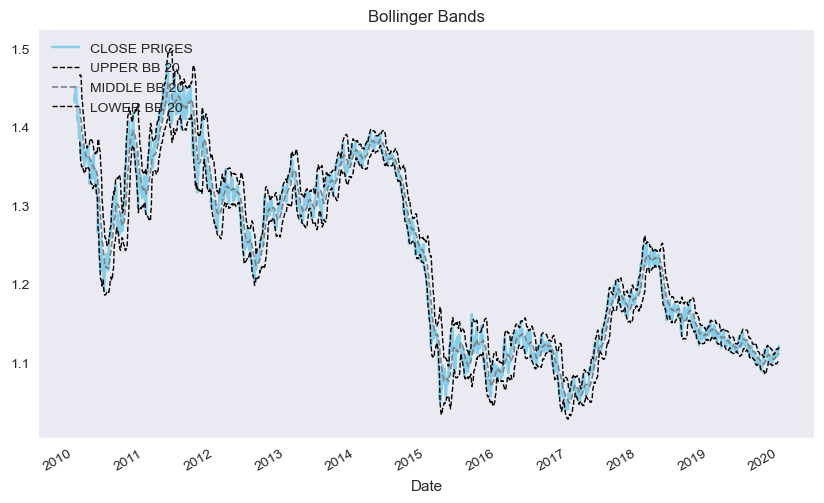

In [54]:
#Plot the figures with the bollinger bands
plt.figure(figsize=(10,6))
plt.title("Bollinger Bands")
pricing_data['Pricing'].plot(label = 'CLOSE PRICES', color = 'skyblue')
pricing_data['Upper Band'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
pricing_data['SMA 20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
pricing_data['Lower Band'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [55]:
#Define a function to generate the trading signals

#If the condition to buy the stock gets satisfied, the buying price will be appended to the ‘buy_price’ list, 
#and the signal value will be appended as 1 representing to buy the stock

#If the condition to sell the stock gets satisfied, the buying price will be appended to the ‘sell_price’ list, 
#and the signal value will be appended as -1 representing to buy the stock

def implement_bands_strategy(data, lower_band, upper_band):
    buy_price = []
    sell_price = []
    bands_signal = []
    signal = 0
    
    for i in range(len(data)):
        if(data[i-1] > lower_band[i-1] and data[i] < lower_band[i]):
            if(signal != 1):
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        elif(data[i-1] < upper_band[i-1] and data[i] > upper_band[i]):
            if(signal != -1):
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bands_signal.append(0)
            
    return buy_price, sell_price, bands_signal

buy_price, sell_price, bands_signal = implement_bands_strategy(pricing_data['Pricing'], pricing_data['Lower Band'], pricing_data['Upper Band'])

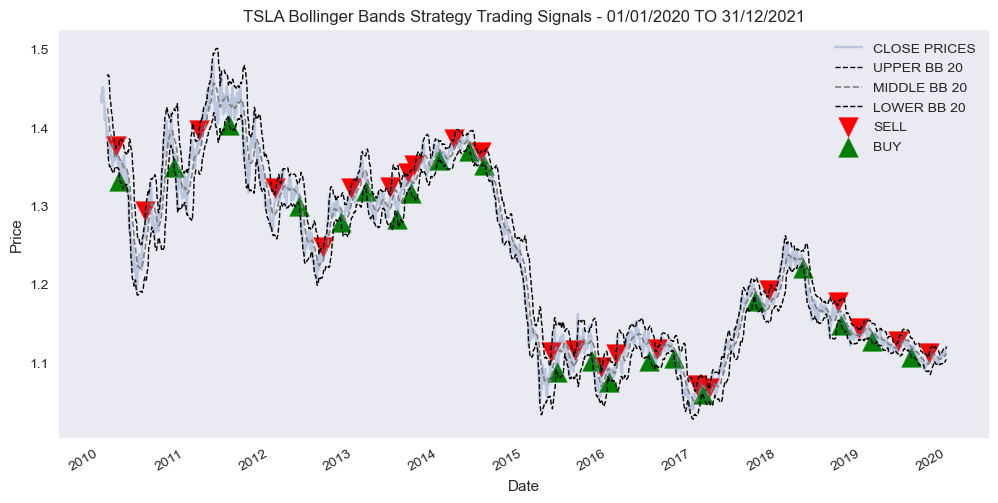

In [56]:
#Plot the figures with the trading signals
plt.figure(figsize = (12,6))
plt.title("TSLA Bollinger Bands Strategy Trading Signals - 01/01/2020 TO 31/12/2021")
pricing_data['Pricing'].plot(label = 'CLOSE PRICES', alpha = 0.3)
pricing_data['Upper Band'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
pricing_data['SMA 20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
pricing_data['Lower Band'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(pricing_data.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.scatter(pricing_data.index, buy_price, marker='^', color = 'green', label = 'BUY', s = 200)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper right')
plt.grid()
plt.show()

Create positions for our strategy

In [58]:
position = []
for i in range(len(bands_signal)):
    if bands_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(pricing_data['Pricing'])):
    if bands_signal[i] == 1:
        position[i] = 1
    elif bands_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]

In [59]:
#Add the bands_signal list to the main dataset
pricing_data.insert(loc = 2,column = 'Band Signals', value = bands_signal)

#Add the positions list to the main dataset
pricing_data.insert(loc = 3,column = 'Band Position', value = position)

ValueError: cannot insert Band Signals, already exists

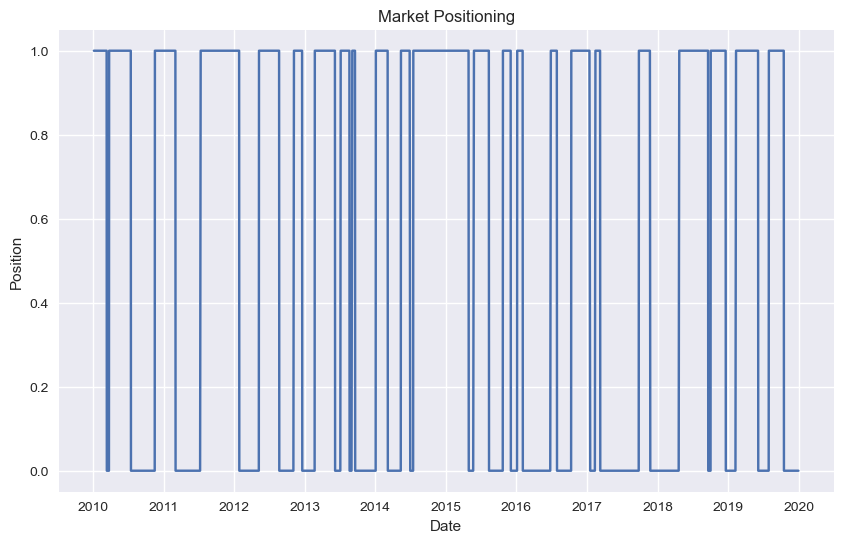

In [62]:
#Plot the market positions
plt.figure(figsize = (10,6))
plt.title("Market Positioning")
plt.xlabel("Date")
plt.ylabel("Position")
plt.plot(pricing_data['Band Position'])

In [42]:
#Calculate the returns on the data
pricing_data['Returns'] = np.log(pricing_data['Pricing'] / pricing_data['Pricing'].shift(1))

In [43]:
#Calculate the performance on the strategy data
pricing_data['Strategy'] = pricing_data['Band Position'].shift(1) * pricing_data['Returns']

In [47]:
#Compute the cummulative returns from the returns dataset
pricing_data['Cummulative Strategy'] = pricing_data['Strategy'].cumsum().apply(np.exp).apply(np.exp)
pricing_data['Cummulative Returns'] = pricing_data['Returns'].cumsum().apply(np.exp)

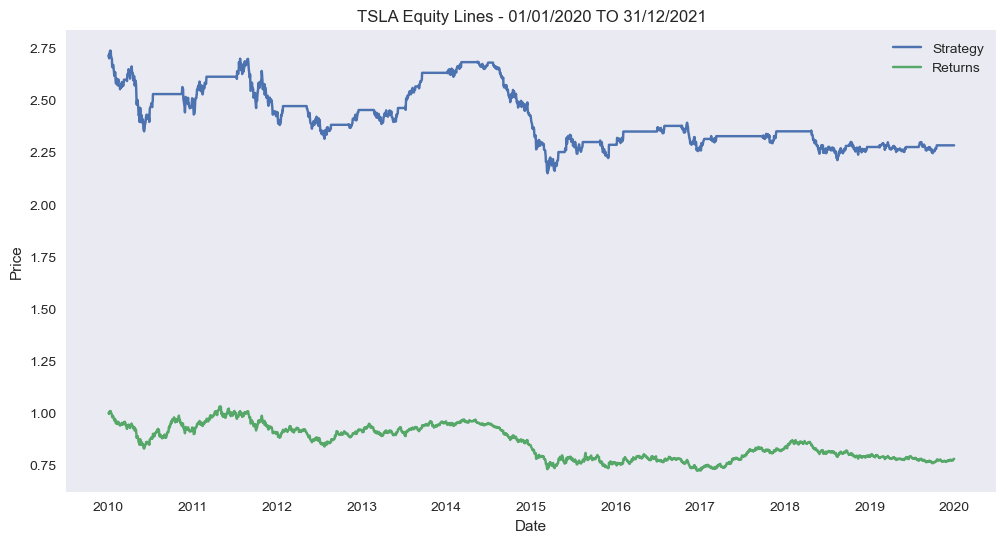

In [64]:
#Plot the figures with the trading signals
plt.figure(figsize = (12,6))
plt.title("TSLA Equity Lines - 01/01/2020 TO 31/12/2021")
plt.plot(pricing_data['Cummulative Strategy'], label = "Strategy")
plt.plot(pricing_data['Cummulative Returns'], label = "Returns")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper right')
plt.grid()
plt.show()